Model 1 Metrics:
Accuracy: 0.8571538461538462
Precision: 0.8539944903581267
Recall: 0.07806597834298665
F1 Score: 0.1430549146285187

Model 2 Metrics:
Accuracy: 0.8231923076923077
Precision: 0.40794117647058825
Recall: 0.3492822966507177
F1 Score: 0.37633970967304303



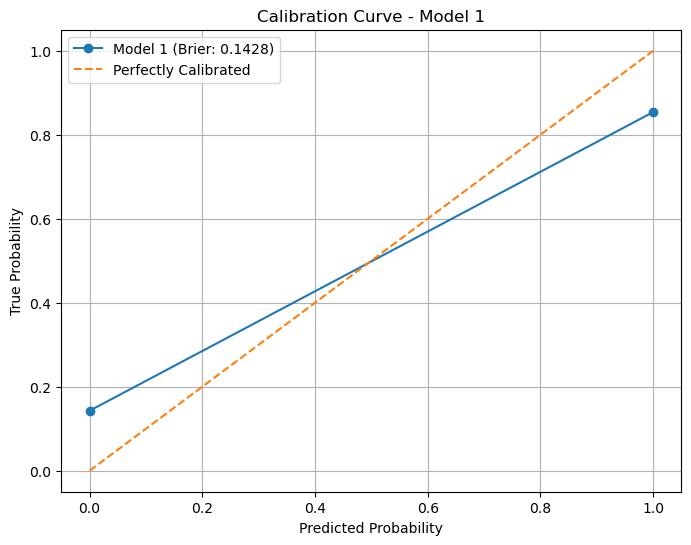

Model 1 Brier Score: 0.1428


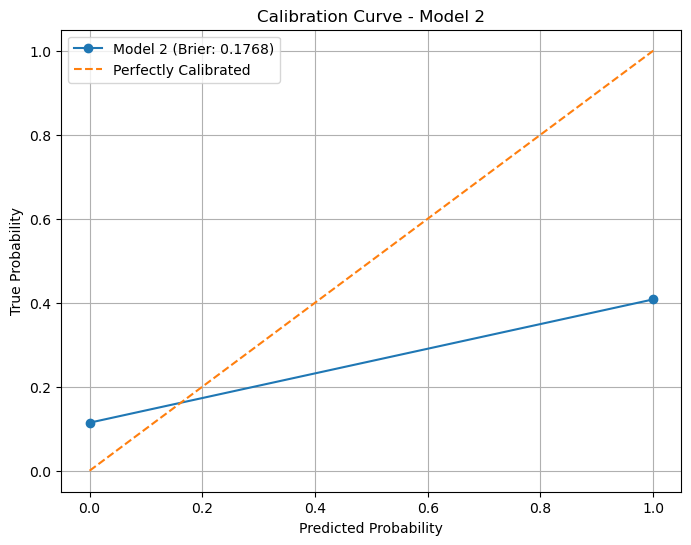

Model 2 Brier Score: 0.1768
Fairness Metrics by Sensitive Feature for Model 1:
                        selection_rate  accuracy
persoon_geslacht_vrouw                          
0                             0.016718  0.852013
1                             0.011058  0.862570
Equalized Odds Difference for Model 1: 0.022226879486653875

Fairness Metrics by Sensitive Feature for Model 2:
                        selection_rate  accuracy
persoon_geslacht_vrouw                          
0                             0.108329  0.833121
1                             0.154411  0.812732
Equalized Odds Difference for Model 2: 0.07079364885110045

Model 1 Accuracy with Noise: 0.8571538461538462
Model 2 Accuracy with Noise: 0.8228461538461539


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference
import onnxruntime as rt
import matplotlib.pyplot as plt

data = pd.read_csv('../data/investigation_train_large_checked.csv')

y = data['checked']
X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_path_1 = "../Group 9/model_1.onnx"
model_path_2 = "../Group 9/model_2.onnx"
session_1 = rt.InferenceSession(model_path_1)
session_2 = rt.InferenceSession(model_path_2)

y_prob_1 = session_1.run(None, {'X': X_test.values.astype(np.float32)})[0].flatten()
y_prob_2 = session_2.run(None, {'X': X_test.values.astype(np.float32)})[0].flatten()

y_pred_1 = np.rint(y_prob_1).astype(int)
y_pred_2 = np.rint(y_prob_2).astype(int)

def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

print_metrics(y_test, y_pred_1, "Model 1")
print_metrics(y_test, y_pred_2, "Model 2")

def calibration_test(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    brier_score = brier_score_loss(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=f'{model_name} (Brier: {brier_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.title(f'Calibration Curve - {model_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{model_name} Brier Score: {brier_score:.4f}")

calibration_test(y_test, y_prob_1, "Model 1")
calibration_test(y_test, y_prob_2, "Model 2")

X_test['persoon_geslacht_vrouw'] = data.loc[X_test.index, 'persoon_geslacht_vrouw']
X_test['persoon_leeftijd_bij_onderzoek'] = data.loc[X_test.index, 'persoon_leeftijd_bij_onderzoek']

sensitive_feature = 'persoon_geslacht_vrouw'

def fairness_test(y_true, y_pred, sensitive_feature, model_name):
    metric_frame = MetricFrame(
        metrics={'selection_rate': selection_rate, 'accuracy': accuracy_score},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=X_test[sensitive_feature]
    )
    print(f"Fairness Metrics by Sensitive Feature for {model_name}:")
    print(metric_frame.by_group)

    equalized_odds = equalized_odds_difference(
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=X_test[sensitive_feature]
    )
    print(f"Equalized Odds Difference for {model_name}: {equalized_odds}\n")

fairness_test(y_test, y_pred_1, sensitive_feature, "Model 1")
fairness_test(y_test, y_pred_2, sensitive_feature, "Model 2")

def noise_resilience_test(session, X_test, y_test, model_name):
    X_test_noisy = X_test.copy()
    noise = np.random.normal(0, 0.1, X_test_noisy.shape)
    X_test_noisy += noise

    y_prob_noisy = session.run(None, {'X': X_test_noisy.values.astype(np.float32)})[0].flatten()
    y_pred_noisy = np.rint(y_prob_noisy).astype(int)

    accuracy_noisy = accuracy_score(y_test, y_pred_noisy)
    print(f"{model_name} Accuracy with Noise: {accuracy_noisy}")

noise_resilience_test(session_1, X_test, y_test, "Model 1")
noise_resilience_test(session_2, X_test, y_test, "Model 2")
